In [1]:
!nvidia-smi
#using a Tesla K80 for reproducibility

Tue Jun  2 19:47:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install backpack-for-pytorch

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True) 

import sys
sys.path.append('/content/gdrive/My Drive/PhD/')

Mounted at /content/gdrive/


In [4]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC, DiagHessian
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
import matplotlib.pyplot as plt
from DirLPA_utils import * 

print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())

s = 127
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pytorch version:  1.5.0+cu101
cuda available:  True


# Load data

Files already downloaded and verified
Files already downloaded and verified


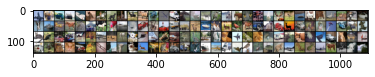

In [5]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='/content/gdrive/My Drive/PhD/data', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='/content/gdrive/My Drive/PhD/data', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified
Files already downloaded and verified


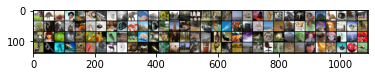

In [6]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='/content/gdrive/My Drive/PhD/data', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='/content/gdrive/My Drive/PhD/data', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Using downloaded and verified file: /content/gdrive/My Drive/PhD/data/train_32x32.mat
Using downloaded and verified file: /content/gdrive/My Drive/PhD/data/test_32x32.mat


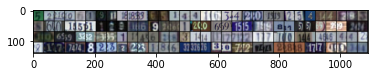

In [7]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

#'~/data/SVHN'
train_data_SVHN = torchvision.datasets.SVHN('/content/gdrive/My Drive/PhD/data', split='train',
                             download=True, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('/content/gdrive/My Drive/PhD/data', split='test',
                             download=True, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, num_of_channels=3):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(num_of_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.linear(out)
        return out

    def features(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18(num_of_channels=3, num_classes=10):
    if num_classes <= 2:
        num_classes = 1

    return ResNet(BasicBlock, [2,2,2,2],
                  num_of_channels=num_of_channels,
                  num_classes=num_classes)

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
SVHN_model = ResNet18().to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SVHN_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [0]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [0]:
def test(net, epoch, testloader, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc and save: 
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)


        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [0]:
def train_all():
    SVHN_path = '/content/gdrive/My Drive/PhD/weights/SVHN_resnet18_SGD.pth'
    SVHN_path_best = '/content/gdrive/My Drive/PhD/weights/SVHN_resnet18_SGD_best.pth'
    lr = 0.1
    epoch = 0
    for e in [10, 10, 5]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(SVHN_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(SVHN_model, epoch, optimizer, SVHN_train_loader, SVHN_path)
            test(SVHN_model, epoch, SVHN_test_loader, SVHN_path_best, save=True)
            epoch += 1
        lr /= 10

In [0]:
#train_all()

In [16]:
##### if you already have a trained model ##############
#CIFAR10_PATH = 'weights/CIFAR10_pretrained.pt'
SVHN_PATH = '/content/gdrive/My Drive/PhD/weights/SVHN_resnet18_SGD_best.pth'
SVHN_model = ResNet18().to(device)
print("loading model from: {}".format(SVHN_PATH))
SVHN_model.load_state_dict(torch.load(SVHN_PATH))#, map_location=torch.device('cpu')))
#test the model
test(SVHN_model, 0, SVHN_test_loader, save=False, path=SVHN_PATH)

loading model from: /content/gdrive/My Drive/PhD/weights/SVHN_resnet18_SGD_best.pth
test loss:  0.5518008781364188
current acc: 1.0; best acc: 0


# prepare Gaussians (Diag and KFAC)

In [0]:
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=SVHN_model,
                                                               train_loader=SVHN_train_loader,
                                                               prec0 = 10,
                                                               device=device)

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/204
Batch: 1/204
Batch: 2/204
Batch: 3/204
Batch: 4/204
Batch: 5/204
Batch: 6/204
Batch: 7/204
Batch: 8/204
Batch: 9/204
Batch: 10/204
Batch: 11/204
Batch: 12/204
Batch: 13/204
Batch: 14/204
Batch: 15/204
Batch: 16/204
Batch: 17/204
Batch: 18/204
Batch: 19/204
Batch: 20/204
Batch: 21/204
Batch: 22/204
Batch: 23/204
Batch: 24/204
Batch: 25/204
Batch: 26/204
Batch: 27/204
Batch: 28/204
Batch: 29/204
Batch: 30/204
Batch: 31/204
Batch: 32/204
Batch: 33/204
Batch: 34/204
Batch: 35/204
Batch: 36/204
Batch: 37/204
Batch: 38/204
Batch: 39/204
Batch: 40/204
Batch: 41/204
Batch: 42/204
Batch: 43/204
Batch: 44/204
Batch: 45/204
Batch: 46/204
Batch: 47/204
Batch: 48/204
Batch: 49/204
Batch: 50/204
Batch: 51/204
Batch: 52/204
Batch: 53/204
Batch: 54/204
Batch: 55/204
Batch: 56/204
Batch: 57/204
Batch: 58/204
Batch: 59/204
Batch: 60/204
Batch: 61/204
Batch: 62/204
Batch: 63/204
Batch: 64/204
Batch: 65/204
Batch: 66/204
Batch: 67/204
Batch: 68

In [17]:
M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K = KFLP_second_order(model=SVHN_model,
                                                               train_loader=SVHN_train_loader,
                                                               batch_size=BATCH_SIZE_TRAIN_SVHN,
                                                               var0 = 5,
                                                               device=device)

Batch: 0/204
Batch: 1/204
Batch: 2/204
Batch: 3/204
Batch: 4/204
Batch: 5/204
Batch: 6/204
Batch: 7/204
Batch: 8/204
Batch: 9/204
Batch: 10/204
Batch: 11/204
Batch: 12/204
Batch: 13/204
Batch: 14/204
Batch: 15/204
Batch: 16/204
Batch: 17/204
Batch: 18/204
Batch: 19/204
Batch: 20/204
Batch: 21/204
Batch: 22/204
Batch: 23/204
Batch: 24/204
Batch: 25/204
Batch: 26/204
Batch: 27/204
Batch: 28/204
Batch: 29/204
Batch: 30/204
Batch: 31/204
Batch: 32/204
Batch: 33/204
Batch: 34/204
Batch: 35/204
Batch: 36/204
Batch: 37/204
Batch: 38/204
Batch: 39/204
Batch: 40/204
Batch: 41/204
Batch: 42/204
Batch: 43/204
Batch: 44/204
Batch: 45/204
Batch: 46/204
Batch: 47/204
Batch: 48/204
Batch: 49/204
Batch: 50/204
Batch: 51/204
Batch: 52/204
Batch: 53/204
Batch: 54/204
Batch: 55/204
Batch: 56/204
Batch: 57/204
Batch: 58/204
Batch: 59/204
Batch: 60/204
Batch: 61/204
Batch: 62/204
Batch: 63/204
Batch: 64/204
Batch: 65/204
Batch: 66/204
Batch: 67/204
Batch: 68/204
Batch: 69/204
Batch: 70/204
Batch: 71/204
Ba

In [0]:
targets_CIFAR10 = CIFAR10_testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in SVHN_test_loader:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [0]:
#number of samples to draw from the Gaussian
num_samples = 100

# MAP estimate

In [0]:
SVHN_test_in_MAP = predict_MAP(SVHN_model, SVHN_test_loader, cuda=cuda_status).cpu().numpy()
SVHN_test_out_CIFAR100_MAP = predict_MAP(SVHN_model, CIFAR100_test_loader, cuda=cuda_status).cpu().numpy()
SVHN_test_out_CIFAR10_MAP = predict_MAP(SVHN_model, CIFAR10_test_loader, cuda=cuda_status).cpu().numpy()

In [0]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(SVHN_test_in_MAP, targets_SVHN)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR10_MAP, targets_CIFAR10)

In [0]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'SVHN', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')

[In, MAP, SVHN] Accuracy: 1.000; average entropy: 0.015;     MMC: 0.997; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.013; Average entropy: 0.948;    MMC: 0.682; AUROC: 0.985; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.093; Average entropy: 0.959;    MMC: 0.680; AUROC: 0.986; Prob @ correct: 0.100


In [0]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.997, 0.997, 0.997, 0.997, 0.997]
mmc_out_CIFAR100 = [0.682, 0.682, 0.682, 0.682, 0.682]
mmc_out_CIFAR10 = [0.680, 0.680, 0.680, 0.680, 0.680]

auroc_out_CIFAR100 = [0.985, 0.985, 0.985, 0.985, 0.985]
auroc_out_CIFAR10 = [0.986, 0.985, 0.986, 0.986, 0.986]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))

accuracy: 1.000 with std 0.000
MMC in: 0.997 with std 0.000
MMC out CIFAR100: 0.682 with std 0.000
MMC out CIFAR10: 0.680 with std 0.000
AUROC out CIFAR100: 0.985 with std 0.000
AUROC out CIFAR10: 0.986 with std 0.000


# Diagonal estimate

In [0]:
SVHN_test_in_D = predict_diagonal_sampling(SVHN_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_D = predict_diagonal_sampling(SVHN_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_D = predict_diagonal_sampling(SVHN_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()

time used for sampling with 100 samples: 3.3722949028015137
time used for sampling with 100 samples: 1.2682092189788818
time used for sampling with 100 samples: 1.3052756786346436


In [0]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(SVHN_test_in_D, targets_SVHN)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR10_D, targets_CIFAR10)

In [0]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'SVHN', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR10', 'Diag')

[In, Diag, SVHN] Accuracy: 1.000; average entropy: 0.080;     MMC: 0.986; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.013; Average entropy: 0.948;    MMC: 0.595; AUROC: 0.983; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR10] Accuracy: 0.094; Average entropy: 1.207;    MMC: 0.594; AUROC: 0.984; Prob @ correct: 0.100


In [0]:
#Diag Sampling with 100 samples
#seeds are 123,124,125,126,127
time_lpb_in = [3.9986681938171387, 3.7951226234436035, 3.279271364212036, 3.3235092163085938, 3.3722949028015137]
time_lpb_out_CIFAR100 = [1.5319528579711914, 1.513995885848999, 1.2755107879638672, 1.3118302822113037, 1.2682092189788818]
time_lpb_out_CIFAR10 = [1.5458652973175049, 1.4645321369171143, 1.3068592548370361, 1.2760159969329834, 1.3052756786346436]

acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.986, 0.986, 0.986, 0.986, 0.986]
mmc_out_CIFAR100 = [0.596, 0.595, 0.596, 0.596, 0.595]
mmc_out_CIFAR10 = [0.594, 0.594, 0.594, 0.594, 0.594]

auroc_out_CIFAR100 = [0.983, 0.983, 0.983, 0.983, 0.983]
auroc_out_CIFAR10 = [0.984, 0.984, 0.984, 0.984, 0.984]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Sampling Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))

Sampling Bridge time in: 3.554 with std 0.289
Sampling Bridge time out CIFAR100: 1.380 with std 0.118
Sampling Bridge time out CIFAR10: 1.380 with std 0.106
accuracy: 1.000 with std 0.000
MMC in: 0.986 with std 0.000
MMC out CIFAR100: 0.596 with std 0.000
MMC out CIFAR10: 0.594 with std 0.000
AUROC out CIFAR100: 0.983 with std 0.000
AUROC out CIFAR10: 0.984 with std 0.000


In [0]:
#Diag Sampling
#seeds are 123,124,125,126,127
time_lpb_in = [34.120339155197144, 32.70909905433655, 35.31439709663391, 35.6839382648468, 34.836057901382446]
time_lpb_out_CIFAR100 = [13.225116729736328, 12.812023878097534, 13.643007755279541, 13.852547883987427, 13.35260009765625]
time_lpb_out_CIFAR10 = [13.263485193252563, 12.797343730926514, 13.490494728088379, 13.855424165725708, 13.334022760391235]

acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.986, 0.986, 0.986, 0.986, 0.986]
mmc_out_CIFAR100 = [0.595, 0.595, 0.595, 0.595, 0.595]
mmc_out_CIFAR10 = [0.593, 0.593, 0.593, 0.593, 0.593]

auroc_out_CIFAR100 = [0.983, 0.984, 0.984, 0.984, 0.984]
auroc_out_CIFAR10 = [0.984, 0.984, 0.984, 0.984, 0.984]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Sampling Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))

Sampling Bridge time in: 34.533 with std 1.051
Sampling Bridge time out CIFAR100: 13.377 with std 0.358
Sampling Bridge time out CIFAR10: 13.348 with std 0.343
accuracy: 1.000 with std 0.000
MMC in: 0.986 with std 0.000
MMC out CIFAR100: 0.595 with std 0.000
MMC out CIFAR10: 0.593 with std 0.000
AUROC out CIFAR100: 0.984 with std 0.000
AUROC out CIFAR10: 0.984 with std 0.000


# KFAC estimate

In [0]:
SVHN_test_in_K = predict_KFAC_sampling(SVHN_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_K = predict_KFAC_sampling(SVHN_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_K = predict_KFAC_sampling(SVHN_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()

time used for sampling with 100 samples: 3.332401752471924
time used for sampling with 100 samples: 1.2696962356567383
time used for sampling with 100 samples: 1.324411392211914


In [0]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(SVHN_test_in_K, targets_SVHN)
acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K = get_out_dist_values(SVHN_test_in_K, SVHN_test_out_CIFAR100_K, targets_CIFAR100)
acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K = get_out_dist_values(SVHN_test_in_K, SVHN_test_out_CIFAR10_K, targets_CIFAR10)

In [0]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'SVHN', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K, 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K, 'CIFAR10', 'KFAC')

[In, KFAC, SVHN] Accuracy: 1.000; average entropy: 0.250;     MMC: 0.950; Prob @ correct: 0.100
[Out-KFAC, KFAC, CIFAR100] Accuracy: 0.013; Average entropy: 0.948;    MMC: 0.467; AUROC: 0.985; Prob @ correct: 0.100
[Out-KFAC, KFAC, CIFAR10] Accuracy: 0.091; Average entropy: 1.587;    MMC: 0.464; AUROC: 0.986; Prob @ correct: 0.100


In [0]:
#KFAC approximation of the Hessian with 100 samples
#seeds are 123,124,125,126,127
time_lpb_in = [4.0519044399261475, 3.815951347351074, 3.322382926940918, 3.3408408164978027, 3.332401752471924]
time_lpb_out_CIFAR100 = [1.5398781299591064, 1.4725701808929443, 1.3332500457763672, 1.2932138442993164, 1.2696962356567383]
time_lpb_out_CIFAR10 = [1.539153814315796, 1.4754104614257812, 1.2939484119415283, 1.3197236061096191, 1.324411392211914]


acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.950, 0.945, 0.945, 0.949, 0.950]
mmc_out_CIFAR100 = [0.467, 0.459, 0.458, 0.464, 0.467]
mmc_out_CIFAR10 = [0.464, 0.456, 0.456, 0.462, 0.464]

auroc_out_CIFAR100 = [0.984, 0.984, 0.985, 0.985, 0.985]
auroc_out_CIFAR10 = [0.984, 0.985, 0.986, 0.986, 0.986]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))

Laplace Bridge time in: 3.573 with std 0.304
Laplace Bridge time out CIFAR100: 1.382 with std 0.106
Laplace Bridge time out CIFAR10: 1.391 with std 0.098
accuracy: 1.000 with std 0.000
MMC in: 0.948 with std 0.002
MMC out CIFAR100: 0.463 with std 0.004
MMC out CIFAR10: 0.460 with std 0.004
AUROC out CIFAR100: 0.985 with std 0.000
AUROC out CIFAR10: 0.985 with std 0.001


In [0]:
#KFAC approximation of the Hessian with 1000 samples
#seeds are 123,124,125,126,127
time_lpb_in = [34.56914448738098, 32.64999747276306, 35.811623096466064, 35.6665461063385, 34.82738733291626]
time_lpb_out_CIFAR100 = [13.287287473678589, 12.679356098175049, 13.774077892303467, 14.13087773323059, 13.549449443817139]
time_lpb_out_CIFAR10 = [13.29854702949524, 12.54148530960083, 13.850192308425903, 13.90602421760559, 13.39912748336792]


acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.950, 0.945, 0.945, 0.949, 0.950]
mmc_out_CIFAR100 = [0.465, 0.456, 0.457, 0.463, 0.465]
mmc_out_CIFAR10 = [0.462, 0.454, 0.454, 0.460, 0.462]

auroc_out_CIFAR100 = [0.985, 0.985, 0.986, 0.986, 0.985]
auroc_out_CIFAR10 = [0.985, 0.985, 0.986, 0.986, 0.986]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))

Laplace Bridge time in: 34.705 with std 1.132
Laplace Bridge time out CIFAR100: 13.484 with std 0.488
Laplace Bridge time out CIFAR10: 13.399 with std 0.491
accuracy: 1.000 with std 0.000
MMC in: 0.948 with std 0.002
MMC out CIFAR100: 0.461 with std 0.004
MMC out CIFAR10: 0.458 with std 0.004
AUROC out CIFAR100: 0.985 with std 0.000
AUROC out CIFAR10: 0.986 with std 0.000


# Laplace Bridge estimate

In [0]:
SVHN_test_in_LB = predict_LB(SVHN_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_LB = predict_LB(SVHN_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_LB = predict_LB(SVHN_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()

total time used for transform: 0.07178
total time used for transform: 0.02764
total time used for transform: 0.02819


In [0]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
SVHN_test_in_LBn = SVHN_test_in_LB/SVHN_test_in_LB.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR100_LBn = SVHN_test_out_CIFAR100_LB/SVHN_test_out_CIFAR100_LB.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR10_LBn = SVHN_test_out_CIFAR10_LB/SVHN_test_out_CIFAR10_LB.sum(1).reshape(-1,1)

In [0]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(SVHN_test_in_LBn, targets_SVHN)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(SVHN_test_in_LBn, SVHN_test_out_CIFAR100_LBn, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(SVHN_test_in_LBn, SVHN_test_out_CIFAR10_LBn, targets_CIFAR10)

In [0]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB, 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB, 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 1.000; average entropy: 0.042;     MMC: 0.993; Prob @ correct: 0.100
[Out-Laplace Bridge, KFAC, CIFAR100] Accuracy: 0.013; Average entropy: 1.490;    MMC: 0.526; AUROC: 0.985; Prob @ correct: 0.100
[Out-Laplace Bridge, KFAC, CIFAR10] Accuracy: 0.093; Average entropy: 1.507;    MMC: 0.520; AUROC: 0.987; Prob @ correct: 0.100


In [0]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.08552, 0.06864, 0.06926, 0.07149, 0.07060]
time_lpb_out_CIFAR100 = [0.03016, 0.02554, 0.02627, 0.02737, 0.02666]
time_lpb_out_CIFAR10 = [0.03048, 0.02468, 0.02744, 0.02957, 0.02936]


acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.993, 0.993, 0.993, 0.993, 0.992]
mmc_out_CIFAR100 = [0.526, 0.526, 0.526, 0.526, 0.526]
mmc_out_CIFAR10 = [0.520, 0.520, 0.520, 0.520, 0.520]

auroc_out_CIFAR100 = [0.985, 0.985, 0.985, 0.985, 0.985]
auroc_out_CIFAR10 = [0.987, 0.987, 0.987, 0.987, 0.987]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))

Laplace Bridge time in: 0.073 with std 0.006
Laplace Bridge time out CIFAR100: 0.027 with std 0.002
Laplace Bridge time out CIFAR10: 0.028 with std 0.002
accuracy: 1.000 with std 0.000
MMC in: 0.993 with std 0.000
MMC out CIFAR100: 0.526 with std 0.000
MMC out CIFAR10: 0.520 with std 0.000
AUROC out CIFAR100: 0.985 with std 0.000
AUROC out CIFAR10: 0.987 with std 0.000


# Laplace Bridge KFAC

In [19]:
SVHN_test_in_LB_KFAC = predict_LB_KFAC(SVHN_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_LB_KFAC = predict_LB_KFAC(SVHN_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_LB_KFAC = predict_LB_KFAC(SVHN_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, timing=True).cpu().numpy()

total time used for transform: 0.04525
total time used for transform: 0.01712
total time used for transform: 0.01842


In [0]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
SVHN_test_in_LB_KFACn = SVHN_test_in_LB_KFAC/SVHN_test_in_LB_KFAC.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR100_LB_KFACn = SVHN_test_out_CIFAR100_LB_KFAC/SVHN_test_out_CIFAR100_LB_KFAC.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR10_LB_KFACn = SVHN_test_out_CIFAR10_LB_KFAC/SVHN_test_out_CIFAR10_LB_KFAC.sum(1).reshape(-1,1)

In [0]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(SVHN_test_in_LB_KFACn, targets_SVHN)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFACn, SVHN_test_out_CIFAR100_LB_KFACn, targets_CIFAR100)
acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFACn, SVHN_test_out_CIFAR10_LB_KFACn, targets_CIFAR10)

In [22]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 1.000; average entropy: 0.042;     MMC: 0.993; Prob @ correct: 0.100
[Out-Laplace Bridge, KFAC, CIFAR100] Accuracy: 0.013; Average entropy: 1.495;    MMC: 0.524; AUROC: 0.985; Prob @ correct: 0.100
[Out-Laplace Bridge, KFAC, CIFAR10] Accuracy: 0.092; Average entropy: 1.517;    MMC: 0.517; AUROC: 0.987; Prob @ correct: 0.100


In [24]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.08552, 0.06864, 0.06926, 0.07149, 0.07060]
time_lpb_out_CIFAR100 = [0.03016, 0.02554, 0.02627, 0.02737, 0.02666]
time_lpb_out_CIFAR10 = [0.03048, 0.02468, 0.02744, 0.02957, 0.02936]


acc_in = [1, 1, 1, 1, 1]
mmc_in = [0.993, 0.993, 0.993, 0.993, 0.993]
mmc_out_CIFAR100 = [0.530, 0.528, 0.525, 0.526, 0.524]
mmc_out_CIFAR10 = [0.524, 0.522, 0.520, 0.519, 0.517]

auroc_out_CIFAR100 = [0.985, 0.985, 0.985, 0.985, 0.985]
auroc_out_CIFAR10 = [0.986, 0.987, 0.987, 0.987, 0.987]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))

Laplace Bridge time in: 0.073 with std 0.006
Laplace Bridge time out CIFAR100: 0.027 with std 0.002
Laplace Bridge time out CIFAR10: 0.028 with std 0.002
accuracy: 1.000 with std 0.000
MMC in: 0.993 with std 0.000
MMC out CIFAR100: 0.527 with std 0.002
MMC out CIFAR10: 0.520 with std 0.002
AUROC out CIFAR100: 0.985 with std 0.000
AUROC out CIFAR10: 0.987 with std 0.000


# Condition

In [0]:
# check if condition holds

def check_condition(alpha_vecs):
    #note that this is vectorized
    alpha_sum = alpha_vecs.sum(1)
    alpha_max = alpha_vecs.max(1)
    alpha_sum_minus = alpha_sum - alpha_max
    right_side = 0.25 * (np.sqrt(9 * alpha_sum_minus**2 + 10 * alpha_sum_minus + 1) - alpha_sum_minus - 1)
    cases = alpha_max > right_side
    percentage = np.sum(cases)/len(cases)
    return(percentage)

In [0]:
print(np.sum(check_condition(SVHN_test_in_LB)))
print(np.sum(check_condition(SVHN_test_out_CIFAR100_LB)))
print(np.sum(check_condition(SVHN_test_out_CIFAR10_LB)))

0.9994622003687769
0.6685
0.6529


In [0]:
condition_SVHN_in = np.array([0.9994622003687769, 0.9994622003687769, 0.9994622003687769, 0.9994622003687769, 0.9994622003687769])
condition_CIFAR100_out = np.array([0.6685, 0.6685, 0.6685, 0.6685, 0.6685])
condition_CIFAR10_out = np.array([0.6529, 0.6529, 0.6529, 0.6529, 0.6529])

print("ratio condition fulfilled SVHN in: {:.03f} with std: {}".format(np.mean(condition_SVHN_in), np.std(condition_SVHN_in)))
print("ratio condition fulfilled CIFAR100 out: {:.03f} with std: {}".format(np.mean(condition_CIFAR100_out), np.std(condition_CIFAR100_out)))
print("ratio condition fulfilled CIFAR10 out: {:.03f} with std: {}".format(np.mean(condition_CIFAR10_out), np.std(condition_CIFAR10_out)))

ratio condition fulfilled SVHN in: 0.999 with std: 1.1102230246251565e-16
ratio condition fulfilled CIFAR100 out: 0.668 with std: 0.0
ratio condition fulfilled CIFAR10 out: 0.653 with std: 0.0
